In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../CommonUtils/') # https://github.com/glukicov/EDMTracking/tree/master/CommonUtils
import CommonUtils as cu
font_size=16

In [102]:
data = pd.read_csv("../DATA/misc/scans/scan.csv")
par_n=-1
if(data.shape[1] == 25):  par_n=9
if(data.shape[1] == 17):  par_n=5
print("par_n =", par_n, "according to expected total columns")
data.info()

par_n = 9 according to expected total columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      127 non-null    float64
 1   A          127 non-null    float64
 2   A_cbo      127 non-null    float64
 3   A_cbo_e    127 non-null    float64
 4   A_e        127 non-null    float64
 5   N          127 non-null    float64
 6   N_e        127 non-null    float64
 7   R          127 non-null    float64
 8   R_e        127 non-null    float64
 9   chi2       127 non-null    float64
 10  ds         127 non-null    object 
 11  n          127 non-null    int64  
 12  ndf        127 non-null    int64  
 13  phi        127 non-null    float64
 14  phi_cbo    127 non-null    float64
 15  phi_cbo_e  127 non-null    float64
 16  phi_e      127 non-null    float64
 17  station    127 non-null    int64  
 18  stop       127 non-null    float64
 19  tau 

In [89]:
# iterators
stations=(12, 18)
dss = ("60h", "9D", "HK", "EG")

In [108]:
#iterative cuts
station=stations[0]
ds=dss[0]

In [109]:
# apply cuts and select data
station_cut = (data["station"]==station)
ds_cut =  (data['ds']==ds)
plot_data= data[station_cut & ds_cut]
# plot_data=plot_data[plot_data['chi2']<1.08]
plot_data=plot_data.reset_index()

In [110]:
# resolve paramters for plotting 
start=plot_data['start']
stop=plot_data['stop']
chi2 = plot_data['chi2']
chi2_e=np.sqrt(2/ (plot_data['ndf']-par_n) )

In [111]:
# get for plotting
x=start
y=chi2
y_e=chi2_e 
y_s = np.sqrt(y_e**2-y_e[0]**2) # 1sigma band

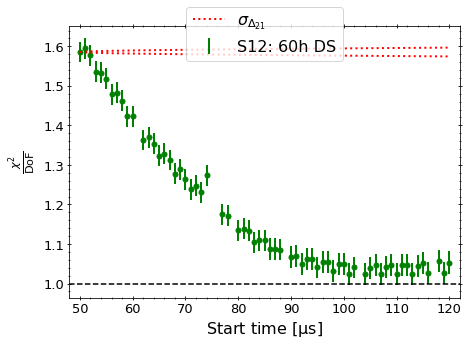

In [112]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=2, label="S"+str(station)+": "+ds+" DS")
ax.plot(x, y, marker=".", ms=10, c="g", lw=0)
ax.plot(x, y[0]+y_s, c="r", ls=":", lw=2, label=r"$\sigma_{\Delta_{21}}$")
ax.plot(x, y[0]-y_s, c="r", ls=":", lw=2)
ax.plot([min(x)-2, max(x)+2], [1, 1], c="k", ls="--")
ax.set_xlim(min(x)-2, max(x)+2)
ax.set_xlabel(r"Start time [$\rm{\mu}$s]", fontsize=font_size);
ax.set_ylabel(r"$\frac{\chi^2}{\rm{DoF}}$", fontsize=font_size);
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig("../fig/start_chi2.png", dpi=300)

In [113]:
y=plot_data['tau']
y_e=plot_data['tau_e']
y_s = np.sqrt(y_e**2-y_e[0]**2) # 1sigma band

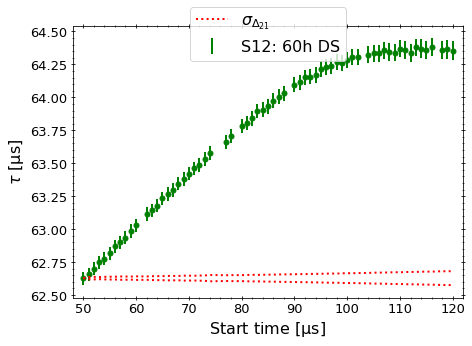

In [114]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=2, label="S"+str(station)+": "+ds+" DS")
ax.plot(x, y, marker=".", ms=10, c="g", lw=0)
ax.plot(x, y[0]+y_s, c="r", ls=":", lw=2, label=r"$\sigma_{\Delta_{21}}$")
ax.plot(x, y[0]-y_s, c="r", ls=":", lw=2)
# ax.plot([min(x)-2, max(x)+2], [1, 1], c="k", ls="--")
ax.set_xlim(min(x)-2, max(x)+2)
ax.set_xlabel(r"Start time [$\rm{\mu}$s]", fontsize=font_size);
ax.set_ylabel(r"$\tau$ [$\rm{\mu}$s]", fontsize=font_size);
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig("../fig/start_LT.png", dpi=300)